In [228]:
## Standard libraries
import numpy as np

## Imports for plotting
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

## PyTorch
import torch

## Torchvision
import torchvision
from torchvision.datasets import SVHN, MNIST, USPS
import torchvision.transforms as T
from torch.utils.data import DataLoader

## Sklearn
from sklearn.manifold import TSNE

## UMAP
try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False

if IN_COLAB:
  print("Using Google Colab")
  !pip install umap-learn
  from umap import UMAP
  !pip install adapt
else:
  from umap import UMAP  

# Path to the folder where the datasets are/should be downloaded
DATASET_PATH = "./data"

In [229]:
# to make the results reproducible
np.random.seed(10)
torch.manual_seed(10)
torch.cuda.manual_seed(10)
torch.mps.manual_seed(10)

In [230]:
print("Using torch", torch.__version__)

if torch.backends.mps.is_available():
    device = torch.device("mps")
    print ("MPS (MacBook) device found.")
    print('Number of MPS cards: ', torch.mps.device_count())
    print('Total MPS memory {0:.2f} GB'.format(torch.mps.recommended_max_memory()/pow(10,9)))
elif torch.backends.cuda.is_built():
    device = torch.device("cuda")
    # Ensure that all operations are deterministic on GPU (if used) for reproducibility
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    print ("CUDA device found.")
    print('Number of GPU cards: ', torch.cuda.device_count(), '\nWhich card GPU?', torch.cuda.get_device_name(0))
    print('Total GPU memory {1:.2f} GB. Free GPU memory {0:.2f} GB'.format(torch.cuda.mem_get_info()[0]/pow(10,9),torch.cuda.mem_get_info()[1]/pow(10,9)))
else:
   device = torch.device("cpu")
   print('No MPS or CUDA has been found. PyTorch will use CPU.')

Using torch 2.5.1
MPS (MacBook) device found.
Number of MPS cards:  1
Total MPS memory 11.45 GB


In this practical session you will implement and test the method presented in [1] for Unsupervised Domain Adaptation.

You will use three imaging datasets showing 0-9 digits: MNIST, SVHN and USPS.

We know that the output spaces are equal (same labels/classes), namely the digits from 0 to 9, and we will resize the data so that the input spaces are also equal (same number of pixels per image).

In this TP, you will assume a covariate shift and therefore that there is a shift between the marginal disitributions $p_S(X)$ and $p_T(X)$ and that the conditionl distributions $p_S(Y|X)$ and $p_t(Y|X)$ are equal.

As for the other TP, answer all questions and fill the code where you see **XXXXXXXXX**

**Deadline**: please verify on the Moodle/Ecampus the deadline



[1] B. Fernando et al. “Unsupervised Visual Domain Adaptation Using Subspace Alignment”. In: ICCV. 2013.

### **MNIST**

 Let's start by downloading the **MNIST** dataset: a very common and large database of grayscale images showing handwritten digits ranging from 0 to 9. It comprises 60,000 training images and 10,000 testing images of size 28x28.

To cope with the assumption about the "same number of input pixels per image", we choose the input dimension of 32x32 for all datasets. We thus resize all images (originally 28x28) using the padding function "Pad" (add 0 to the borders).


In [231]:
# Transform to normalized Tensors in the range [0,1]
MNIST_train_dataset = MNIST(root=DATASET_PATH, train= True, download=True, transform=T.Compose([T.Pad(2), T.ToTensor()]))
MNIST_test_dataset = MNIST(root=DATASET_PATH, train= False, download=True, transform=T.Compose([T.Pad(2), T.ToTensor()]))

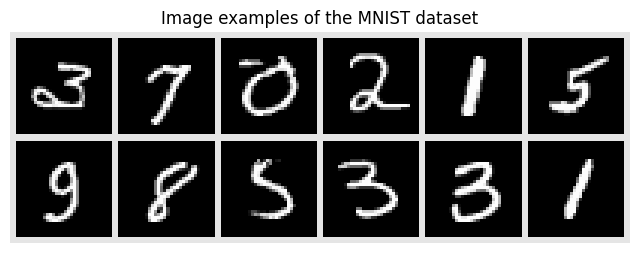

In [232]:
# Visualize some examples
NUM_IMAGES = 12
MNIST_images = torch.stack([MNIST_train_dataset[np.random.randint(len(MNIST_train_dataset))][0] for idx in range(NUM_IMAGES)], dim=0)
img_grid = torchvision.utils.make_grid(MNIST_images, nrow=6, normalize=True, pad_value=0.9)
img_grid = img_grid.permute(1, 2, 0)

plt.figure(figsize=(8,8))
plt.title("Image examples of the MNIST dataset")
plt.imshow(img_grid)
plt.axis('off')
plt.show()
plt.close()

Be careful ! Even if you put a transform when downloading the data and creating the Pytorch Dataset, this is actually not applied until you load the data with a DataLoader.

For instance, when you load images in the range $[0,255]$ and you put the transform `ToTensor()`, this should automatically normalize the images in the range $[0,1]$ and transform them into Pytorch tensors. However, if you simply take the data from the DataSet *WITHOUT* the DataLoader...

In [233]:
#This does not apply the normalization to [0-1] (transform To.Tensor() )
MNIST_Xtrain_255 = MNIST_train_dataset.data.numpy()
MNIST_ytrain_255 = MNIST_train_dataset.targets.numpy()

In [234]:
print(MNIST_Xtrain_255.shape)
print(MNIST_ytrain_255.shape)

print('Min Pixel Value: {} \nMax Pixel Value: {}'.format(MNIST_Xtrain_255.min(), MNIST_Xtrain_255.max()))
print('Mean Pixel Value {} \nPixel Values Std: {}'.format(MNIST_Xtrain_255.mean(), MNIST_Xtrain_255.std()))
print('Min Pixel Value: {} \nMax Pixel Value: {}'.format(MNIST_Xtrain_255.min(), MNIST_Xtrain_255.max()))

(60000, 28, 28)
(60000,)
Min Pixel Value: 0 
Max Pixel Value: 255
Mean Pixel Value 33.318421449829934 
Pixel Values Std: 78.56748998339798
Min Pixel Value: 0 
Max Pixel Value: 255


Instead, if we load them with the Dataloader...

In [235]:
MNIST_train_loader = DataLoader(MNIST_train_dataset, batch_size=len(MNIST_train_dataset))
MNIST_test_loader = DataLoader(MNIST_test_dataset, batch_size=len(MNIST_test_dataset))

MNIST_Xtrain_ima = np.squeeze(next(iter(MNIST_train_loader))[0].numpy())
MNIST_ytrain = next(iter(MNIST_train_loader))[1].numpy()

MNIST_Xtest_ima = np.squeeze(next(iter(MNIST_test_loader))[0].numpy())
MNIST_ytest = next(iter(MNIST_test_loader))[1].numpy()

In [236]:
print(MNIST_Xtrain_ima.shape)
print(MNIST_ytrain.shape)

print(MNIST_Xtest_ima.shape)
print(MNIST_ytest.shape)

print('Min Pixel Value: {} \nMax Pixel Value: {}'.format(MNIST_Xtrain_ima.min(), MNIST_Xtrain_ima.max()))
print('Mean Pixel Value {} \nPixel Values Std: {}'.format(MNIST_Xtrain_ima.mean(), MNIST_Xtrain_ima.std()))

print('Min Pixel Value: {} \nMax Pixel Value: {}'.format(MNIST_Xtest_ima.min(), MNIST_Xtest_ima.max()))
print('Mean Pixel Value {} \nPixel Values Std: {}'.format(MNIST_Xtest_ima.mean(), MNIST_Xtest_ima.std()))

(60000, 32, 32)
(60000,)
(10000, 32, 32)
(10000,)
Min Pixel Value: 0.0 
Max Pixel Value: 1.0
Mean Pixel Value 0.10003671795129776 
Pixel Values Std: 0.2752174437046051
Min Pixel Value: 0.0 
Max Pixel Value: 1.0
Mean Pixel Value 0.10145653039216995 
Pixel Values Std: 0.2774091958999634


(12, 32, 32)


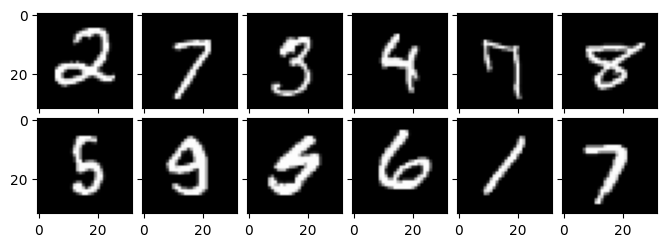

In [237]:
from mpl_toolkits.axes_grid1 import ImageGrid

NUM_IMAGES=12
MNIST_grid = MNIST_Xtrain_ima[np.random.randint(0,len(MNIST_Xtrain_ima),12),:,:]
print(MNIST_grid.shape)

fig = plt.figure(figsize=(8,8))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(2, 6),  # creates 2x2 grid of axes
                 axes_pad=0.1,  # pad between axes in inch.
                 )

for ax, im in zip(grid, MNIST_grid):
    # Iterating over the grid returns the Axes.
    ax.imshow(im,cmap='gray')

plt.show()

So we have 60k training images and 10K test images of size $[32 x 32]$. Let's load another dataset

### **SVHN dataset**

The Street View House Numbers (SVHN) dataset is a real-world image dataset for house number detection. It is similar to MNIST since it has the same digit classes (0 to 9), but it is significantly harder due to its real-world setting. SVHN is obtained from house numbers in Google Street View images.

It comprises RGB images of size $32x32$

We change them from RGB to grayscale to compare them with the MNIST images.


In [238]:
SVHN_train_dataset = SVHN(root=DATASET_PATH, split='train', download=True, transform=T.Compose([T.Grayscale(), T.ToTensor()]))
SVHN_test_dataset = SVHN(root=DATASET_PATH, split='test', download=True, transform=T.Compose([T.Grayscale(), T.ToTensor()]))

Using downloaded and verified file: ./data/train_32x32.mat
Using downloaded and verified file: ./data/test_32x32.mat


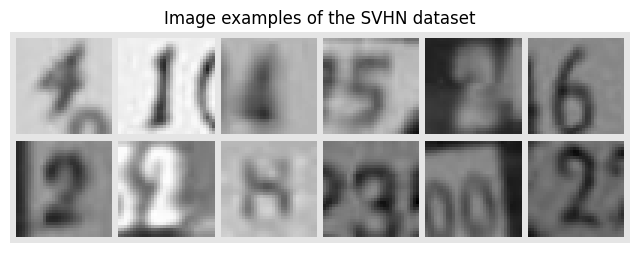

In [239]:
# Visualize some examples
NUM_IMAGES = 12
SVHN_images = torch.stack([SVHN_test_dataset[np.random.randint(len(SVHN_test_dataset))][0] for idx in range(NUM_IMAGES)], dim=0)
img_grid = torchvision.utils.make_grid(SVHN_images, nrow=6, normalize=True, pad_value=0.9)
img_grid = img_grid.permute(1, 2, 0)

plt.figure(figsize=(8,8))
plt.title("Image examples of the SVHN dataset")
plt.imshow(img_grid)
plt.axis('off')
plt.show()
plt.close()

In [240]:
SVHN_train_loader = DataLoader(SVHN_train_dataset, batch_size=len(SVHN_train_dataset))
SVHN_test_loader = DataLoader(SVHN_test_dataset, batch_size=len(SVHN_test_dataset))

SVHN_Xtrain_ima = np.squeeze(next(iter(SVHN_train_loader))[0].numpy())
SVHN_ytrain = next(iter(SVHN_train_loader))[1].numpy()

SVHN_Xtest_ima = np.squeeze(next(iter(SVHN_test_loader))[0].numpy())
SVHN_ytest = next(iter(SVHN_test_loader))[1].numpy()


In [241]:
print(SVHN_Xtrain_ima.shape)
print(SVHN_ytrain.shape)
print(SVHN_Xtest_ima.shape)
print(SVHN_ytest.shape)

print('Min Pixel Value: {} \nMax Pixel Value: {}'.format(SVHN_Xtrain_ima.min(), SVHN_Xtrain_ima.max()))
print('Mean Pixel Value {} \nPixel Values Std: {}'.format(SVHN_Xtrain_ima.mean(), SVHN_Xtrain_ima.std()))

print('Min Pixel Value: {} \nMax Pixel Value: {}'.format(SVHN_Xtest_ima.min(), SVHN_Xtest_ima.max()))
print('Mean Pixel Value {} \nPixel Values Std: {}'.format(SVHN_Xtest_ima.mean(), SVHN_Xtest_ima.std()))

(73257, 32, 32)
(73257,)
(26032, 32, 32)
(26032,)
Min Pixel Value: 0.0 
Max Pixel Value: 1.0
Mean Pixel Value 0.4452594220638275 
Pixel Values Std: 0.196975976228714
Min Pixel Value: 0.0 
Max Pixel Value: 1.0
Mean Pixel Value 0.45435550808906555 
Pixel Values Std: 0.2220025360584259


Here we have ~73K training images and ~26K test images of the same size $[32 x x32]$

### **USPS**

As last dataset, we will use the USPS dataset which contains images of digits (from 0 to 9) scanned from envelopes by the U.S. Postal Service. It contains a total of 9,298 $16x16$ pixel grayscale images. Images are centered, normalized and show a broad range of font styles.

Even in ths case, we pad them with 0 in order to have $32 x 32$ images.

In [242]:
USPS_train_dataset = USPS(root=DATASET_PATH, train= True, download=True, transform=T.Compose([T.Pad(8), T.ToTensor()]))
USPS_test_dataset = USPS(root=DATASET_PATH, train= False, download=True, transform=T.Compose([T.Pad(8), T.ToTensor()]))

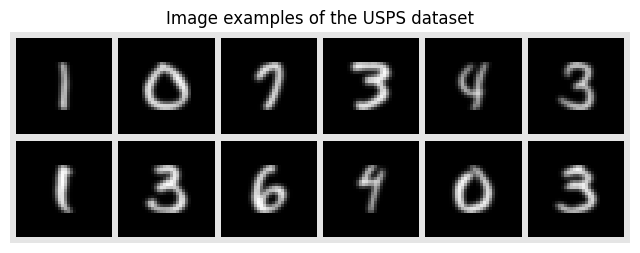

In [243]:
# Visualize some examples
NUM_IMAGES = 12
USPS_images = torch.stack([USPS_train_dataset[np.random.randint(len(USPS_train_dataset))][0] for idx in range(NUM_IMAGES)], dim=0)
img_grid = torchvision.utils.make_grid(USPS_images, nrow=6, normalize=True, pad_value=0.9)
img_grid = img_grid.permute(1, 2, 0)

plt.figure(figsize=(8,8))
plt.title("Image examples of the USPS dataset")
plt.imshow(img_grid)
plt.axis('off')
plt.show()
plt.close()

In [244]:
USPS_train_loader = DataLoader(USPS_train_dataset, batch_size=len(USPS_train_dataset))
USPS_test_loader = DataLoader(USPS_test_dataset, batch_size=len(USPS_test_dataset))

USPS_Xtrain_ima = np.squeeze(next(iter(USPS_train_loader))[0].numpy())
USPS_ytrain = next(iter(USPS_train_loader))[1].numpy()

USPS_Xtest_ima = np.squeeze(next(iter(USPS_test_loader))[0].numpy())
USPS_ytest = next(iter(USPS_test_loader))[1].numpy()

In [245]:
print(USPS_Xtrain_ima.shape)
print(USPS_ytrain.shape)
print(USPS_Xtest_ima.shape)
print(USPS_ytest.shape)

print('Min Pixel Value: {} \nMax Pixel Value: {}'.format(USPS_Xtrain_ima.min(), USPS_Xtrain_ima.max()))
print('Mean Pixel Value {} \nPixel Values Std: {}'.format(USPS_Xtrain_ima.mean(), USPS_Xtrain_ima.std()))

print('Min Pixel Value: {} \nMax Pixel Value: {}'.format(USPS_Xtest_ima.min(), USPS_Xtest_ima.max()))
print('Mean Pixel Value {} \nPixel Values Std: {}'.format(USPS_Xtest_ima.mean(), USPS_Xtest_ima.std()))

(7291, 32, 32)
(7291,)
(2007, 32, 32)
(2007,)
Min Pixel Value: 0.0 
Max Pixel Value: 0.9960784316062927
Mean Pixel Value 0.06171923503279686 
Pixel Values Std: 0.18373751640319824
Min Pixel Value: 0.0 
Max Pixel Value: 1.0
Mean Pixel Value 0.06497029960155487 
Pixel Values Std: 0.19083774089813232


We have ~7K training images and ~2k test images of size $[32 x 32]$

### **UMAP**

One of the first things to do, is to visually check the data to verify if it exists a domain gap and if the datasets are different.

Here, we will use the UMAP and t-SNE methods which are general manifold learning and non-linear dimension reduction algorithms (probably the two most-used ones). UMAP can be seen as a Riemannian extension of the t-SNE method (which uses an Euclidean distance).

[1] Leland McInnes, John Healy, James Melville. "UMAP: Uniform Manifold Approximation and Projection for Dimension Reduction". 2018

[2] van der Maaten, L.J.P., Hinton, G.E. "Visualizing Data Using t-SNE". Journal of Machine Learning Research. 2008


Transform data so that instead than having 3D arrays of images we will have 2D arrays by vectorizing each image -> 32 x 32 = 1024

In [246]:
# MNIST
MNIST_Xtrain = np.reshape(MNIST_Xtrain_ima, (MNIST_Xtrain_ima.shape[0], MNIST_Xtrain_ima.shape[1]**2))
MNIST_Xtest = np.reshape(MNIST_Xtest_ima, (MNIST_Xtest_ima.shape[0], MNIST_Xtest_ima.shape[1]**2))

print(MNIST_Xtrain.shape, MNIST_Xtest.shape)

# USPS
USPS_Xtrain = np.reshape(USPS_Xtrain_ima, (USPS_Xtrain_ima.shape[0], USPS_Xtrain_ima.shape[1]**2))
USPS_Xtest = np.reshape(USPS_Xtest_ima, (USPS_Xtest_ima.shape[0], USPS_Xtest_ima.shape[1]**2))

print(USPS_Xtrain.shape, USPS_Xtest.shape)

# SVHN
SVHN_Xtrain = np.reshape(SVHN_Xtrain_ima, (SVHN_Xtrain_ima.shape[0], SVHN_Xtrain_ima.shape[1]**2))
SVHN_Xtest = np.reshape(SVHN_Xtest_ima, (SVHN_Xtest_ima.shape[0], SVHN_Xtest_ima.shape[1]**2))

print(SVHN_Xtrain.shape, SVHN_Xtest.shape)

(60000, 1024) (10000, 1024)
(7291, 1024) (2007, 1024)
(73257, 1024) (26032, 1024)


Here, we randomly pick only 1000 samples per dataset for visualization and to reduce the computational burden.

In [247]:
# Reduced MNIST
MNIST_reduced_indices = np.random.randint(0, len(MNIST_Xtrain), 1000)
MNIST_Xtrain_res = MNIST_Xtrain[MNIST_reduced_indices, :]
MNIST_ytrain_res = MNIST_ytrain[MNIST_reduced_indices]

# Reduced USPS
USPS_reduced_indices = np.random.randint(0, len(USPS_Xtrain), 1000)
USPS_Xtrain_res = USPS_Xtrain[USPS_reduced_indices, :]
USPS_ytrain_res = USPS_ytrain[USPS_reduced_indices]

# Reduced SVHN
SVHN_reduced_indices = np.random.randint(0, len(SVHN_Xtrain), 1000)
SVHN_Xtrain_res = SVHN_Xtrain[SVHN_reduced_indices, :]
SVHN_ytrain_res = SVHN_ytrain[SVHN_reduced_indices]


# Reduced Data
xtot=np.concatenate((MNIST_Xtrain_res,USPS_Xtrain_res,SVHN_Xtrain_res),axis=0) # all data
nMNIST=MNIST_Xtrain_res.shape[0]
nUSPS=USPS_Xtrain_res.shape[0]
nSVHN=SVHN_Xtrain_res.shape[0]

In [248]:
xp = UMAP().fit_transform(xtot) # this should take ~50sec

print(xp.shape)

# separate again but now in 2D
xpMNIST=xp[:nMNIST,:]
xpUSPS=xp[nMNIST:nMNIST+nUSPS,:]
xpSVHN=xp[nMNIST+nUSPS:,:]

/Users/mjolif/Documents/A-MVA/S2/Representation-learning/TP2/.venv/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


(3000, 2)


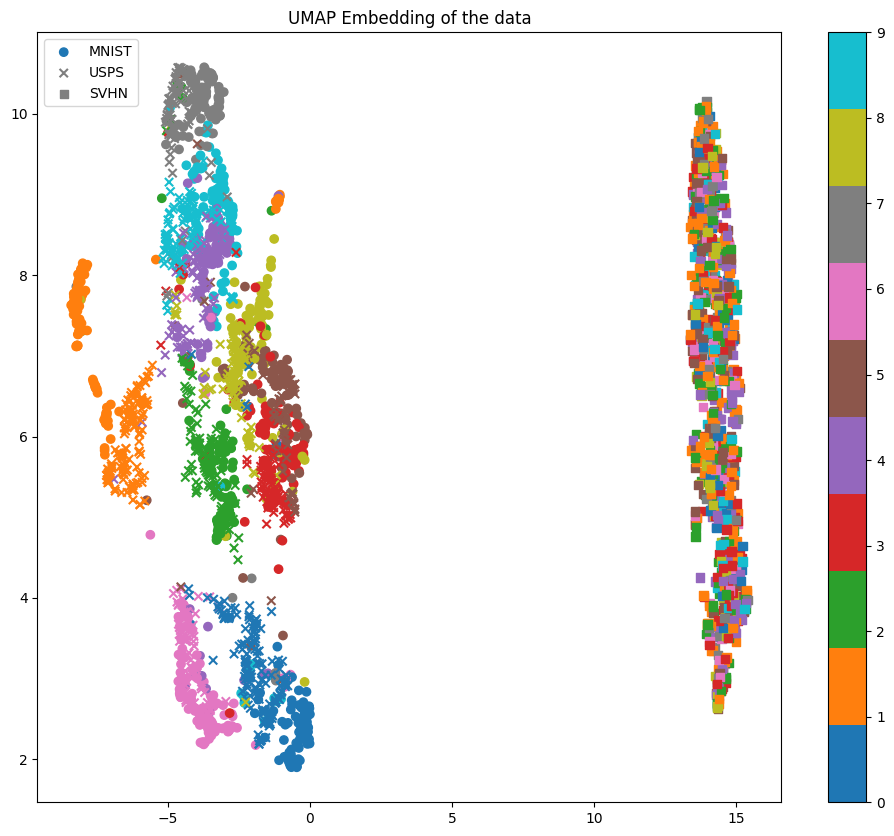

In [249]:
plt.figure(3,(12,10))

plt.scatter(xpMNIST[:,0],xpMNIST[:,1],c=MNIST_ytrain_res,marker='o',cmap='tab10',label='MNIST')
plt.scatter(xpUSPS[:,0],xpUSPS[:,1],c=USPS_ytrain_res,marker='x',cmap='tab10',label='USPS')
plt.scatter(xpSVHN[:,0],xpSVHN[:,1],c=SVHN_ytrain_res,marker='s',cmap='tab10',label='SVHN')
plt.legend()
plt.colorbar()
plt.title('UMAP Embedding of the data')
plt.show()

It seems that one dataset is quite different from the other two.

**Question**: What are your conclusions ? Re-run the code showing only the most similar datasets.

There is probably a domain shift, as one of the datasets is different from the two other ones on the UMAP projection of the data. It can be explained by the fact that both MNIST and USPS are datasets composed of handwritten digits and therefore share some similarities, whereas the SVHN dataset is about house number real-world images, it explains the shift.

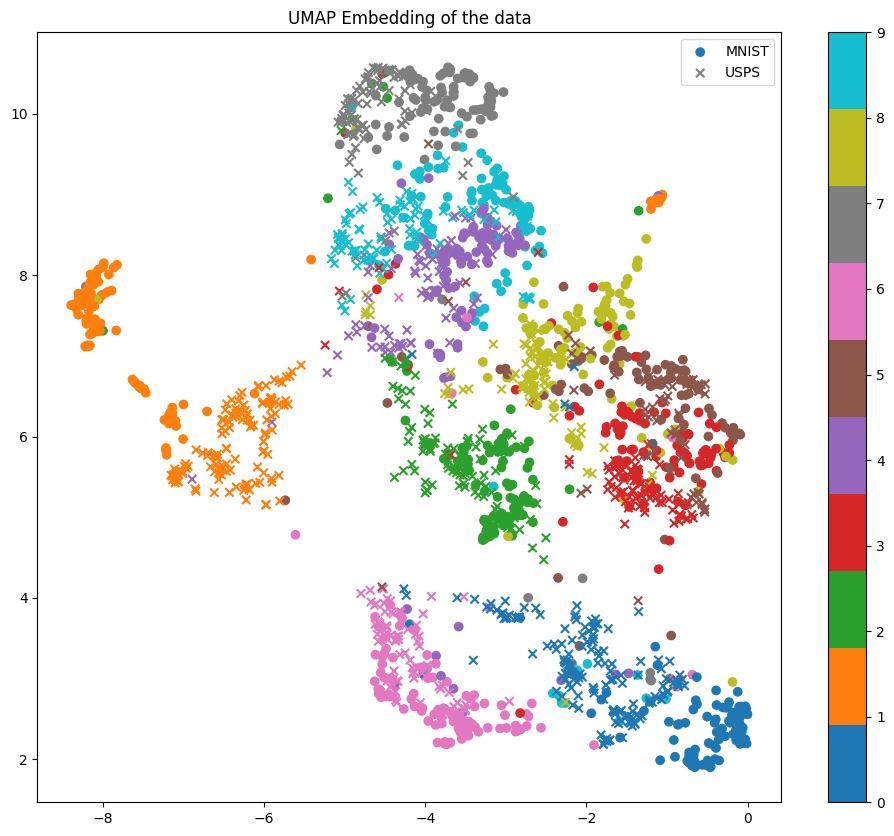

In [250]:
plt.figure(3,(12,10))

plt.scatter(xpMNIST[:,0],xpMNIST[:,1],c=MNIST_ytrain_res,marker='o',cmap='tab10',label='MNIST')
plt.scatter(xpUSPS[:,0],xpUSPS[:,1],c=USPS_ytrain_res,marker='x',cmap='tab10',label='USPS')
plt.legend()
plt.colorbar()
plt.title('UMAP Embedding of the data')
plt.show()

**Question**: Can you see a domain shift between the datasets ?

We still can observe a domain shift between these two datasets. However, this time the shift is much smaller than the previous one. Indeed, the embedding of the 0, 1, 3, 4, 5, 7 and 9 digits are not exactly the same between the USPS and MNIST datasets, but are still close.

Now we can test the t-SNE algorithm to check whether your conclusions are confirmed.

In [251]:
%time xp=TSNE().fit_transform(xtot) # this should take around 50 sec

print(xp.shape)

# separate again but now in 2D
xpMNIST=xp[:nMNIST,:]
xpUSPS=xp[nMNIST:nMNIST+nUSPS,:]
xpSVHN=xp[nMNIST+nUSPS:,:]
print(xpMNIST.shape,xpUSPS.shape,xpSVHN.shape)

CPU times: user 34 s, sys: 6.65 s, total: 40.7 s
Wall time: 5.25 s
(3000, 2)
(1000, 2) (1000, 2) (1000, 2)


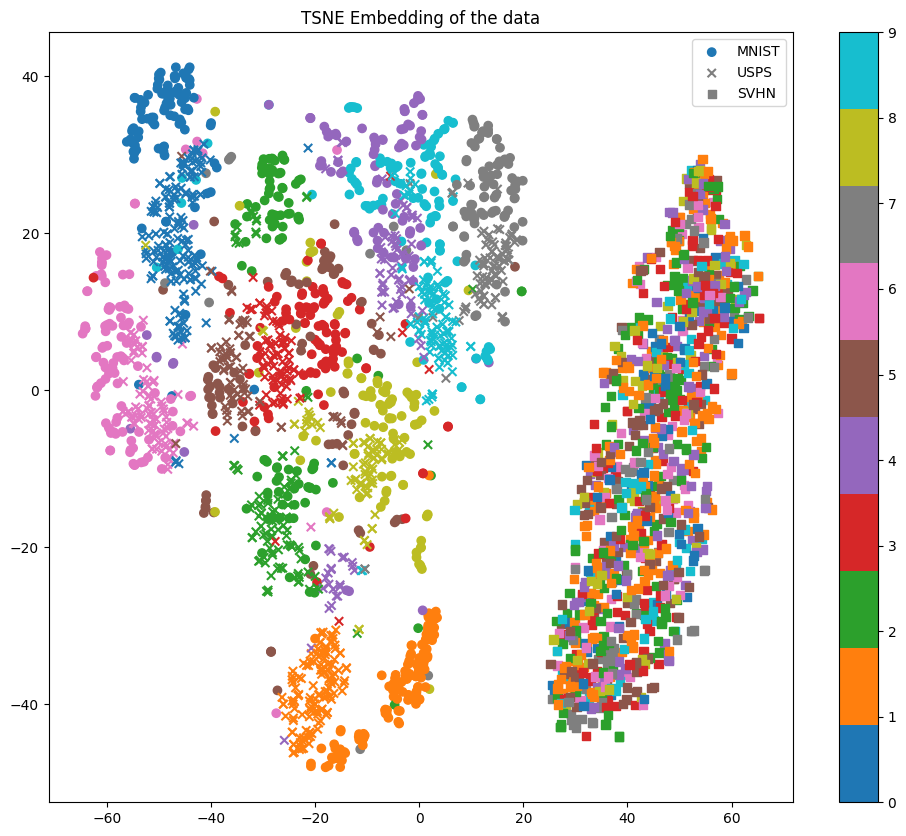

In [252]:
plt.figure(3,(12,10))

plt.scatter(xpMNIST[:,0],xpMNIST[:,1],c=MNIST_ytrain_res,marker='o',cmap='tab10',label='MNIST')
plt.scatter(xpUSPS[:,0],xpUSPS[:,1],c=USPS_ytrain_res,marker='x',cmap='tab10',label='USPS')
plt.scatter(xpSVHN[:,0],xpSVHN[:,1],c=SVHN_ytrain_res,marker='s',cmap='tab10',label='SVHN')
plt.legend()
plt.colorbar()
plt.title('TSNE Embedding of the data')
plt.show()

**Question**: can you confirm your previous conclusions ?

My previous conclusions can be confirmed by this TSNE plot. We observe that the embeddings of the SVHN dataset are quite different from the corresponding embeddings of the two others datasets. We still can observe a little domain shift between the MNIST and USPS datasets.

It seems that one dataset is quite different from the other two data-sets.

**Question**: Analyse that dataset alone using UMAP (faster)

In [253]:
xpSVHN = UMAP().fit_transform(SVHN_Xtrain_res) # this should take ~50sec

print(xpSVHN.shape)

/Users/mjolif/Documents/A-MVA/S2/Representation-learning/TP2/.venv/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


(1000, 2)


In [254]:
SVHN_Xtrain_res

array([[0.7137255 , 0.7058824 , 0.69411767, ..., 0.39215687, 0.39215687,
        0.39215687],
       [0.2627451 , 0.25490198, 0.2509804 , ..., 0.16470589, 0.15686275,
        0.16078432],
       [0.42352942, 0.42745098, 0.40784314, ..., 0.09019608, 0.09411765,
        0.13725491],
       ...,
       [0.6313726 , 0.63529414, 0.6392157 , ..., 0.47843137, 0.48235294,
        0.49411765],
       [0.34509805, 0.3647059 , 0.39215687, ..., 0.19215687, 0.2       ,
        0.20392157],
       [0.5254902 , 0.52156866, 0.5294118 , ..., 0.2784314 , 0.2784314 ,
        0.2784314 ]], dtype=float32)

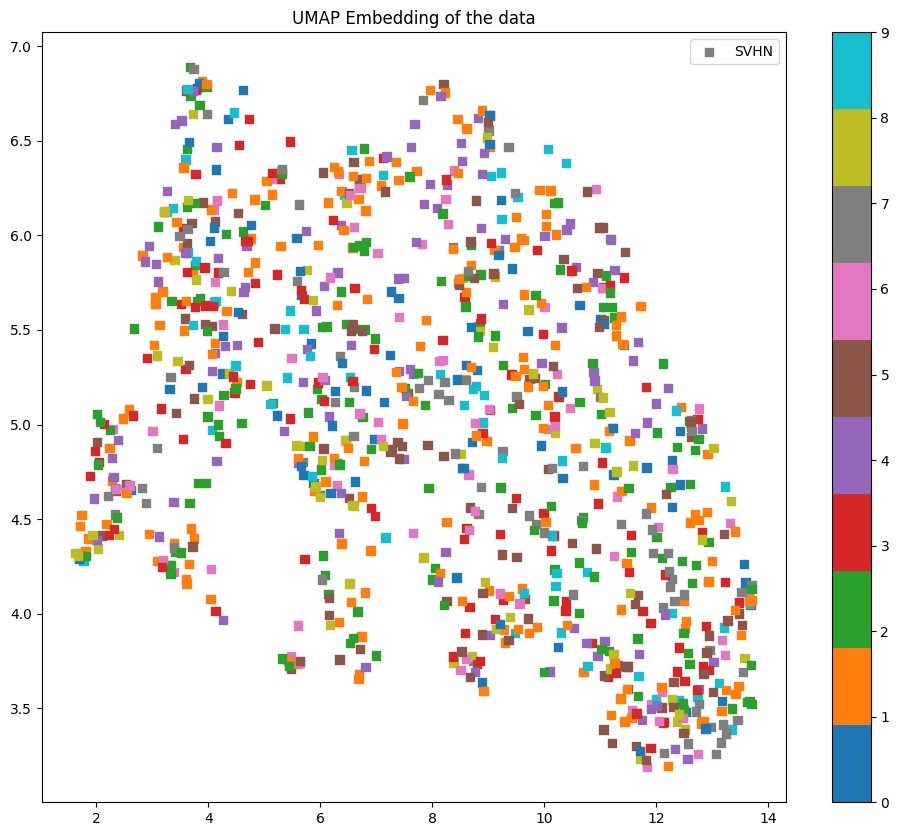

In [255]:
plt.figure(3,(12,10))

plt.scatter(xpSVHN[:,0],xpSVHN[:,1],c=SVHN_ytrain_res,marker='s',cmap='tab10',label='SVHN')
plt.legend()
plt.colorbar()
plt.title('UMAP Embedding of the data')
plt.show()

**Question**: Are the data clearly clustered and well separated as for the other two datasets ? If not, why is that in your opinion ?

Hint: think about the input space of UMAP...

In this case of the UMAP embedding of the SVHN dataset, the data are clearly not clustered and well seperated by digits as it was the case for the other two datasets. It can be first explained by the fact that the house numbers can't be clustered easily by digits, for example for the number "345" should it be clustered as a "3", as a "4" or as a "5" or as something else, this is not very clear. Moreover, the resolution of the images of the SVHN dataset seems to be much lower than the two other datasets and can explain difficulties to capture correctly information from the images. There is probably more variability and diversity of size, fonts or orientation in the SVHN datasets that may lead to difficulties to extract correct information from the images.

# Unsupervised Domain Adaptation

The three data-sets have the same features $\mathcal{X}$ (all images have size $[32 x 32]$)
 and the same classes (output labels) $\mathcal{Y}$ but they have different marginal $p(X)$ distributions.

In this part, we will assume that we only have labeled data in the source domain $S$ but not int the target domain $T$. By matching the source $p_S(X)$ and target $p_T(X)$ marginal distributions, one can hope that a classifier learnt on $S$ will also work on $T$.

Here, you will implement and test the following algorithm based on subspace alignement:

B. Fernando et al. "*Unsupervised Visual Domain Adaptation Using Subspace Alignment*". ICCV, 2013.

The first thing to do is to choose the source domain and the target domain.
Let's start with the MNIST dataset as source and USPS as target.

We will use the previously computed reduced datasets to speed up computations.

In [256]:
# Source domain
XtrainS = MNIST_Xtrain_res
ytrainS = MNIST_ytrain_res
XtestS = MNIST_Xtest
ytestS = MNIST_ytest

# # Target domain
XtrainT = USPS_Xtrain_res
ytrainT = USPS_ytrain_res
XtestT = USPS_Xtest
ytestT = USPS_ytest

# Target domain
# XtrainT = SVHN_Xtrain_res
# ytrainT = SVHN_ytrain_res
# XtestT = SVHN_Xtest
# ytestT = SVHN_ytest

Ns=1000 # number of samples in source domain
Nt=1000 # number of samples in target domain

XtrainS = XtrainS[:Ns,:]
ytrainS = ytrainS[:Ns]
XtestT = XtestT[:Nt,:]
ytrainT = ytrainT[:Nt]
ytestT = ytestT[:Nt]

Implement the method following the description of the method in the slides of the lecture (around slide 75).  

In [257]:
from sklearn.decomposition import PCA

def SA(XTrainS, XTestS, XTrainT, XTestT, d=10):
  """
  Subspace Alignment (SA)

  Input
  XTrainS : Input training source data [NTrS,D]
  XTestS : Input test source data [NTeS,D]
  XTrainT : Input training target data [NTrT,D]
  XTestT : Input test target data [NTeT,D]
  d : number of PCA components

  Output
  XTrainSp : projected and transformed source training data [NTrS,d]
  XTestSp : projected and transformed source test data [NTeS,d]
  XTrainTp : projected training target data [NTrT,d]
  XTestTp : projected test target data [NTeT,d]
  """
  pca_S = PCA().fit(XTrainS)
  pca_T = PCA().fit(XTrainT)
  
  U_S = pca_S.components_.T[:,:d]
  U_T = pca_T.components_.T[:,:d]
  M_star = U_S.T @ U_T
  
  XTrainSp = XTrainS @ U_S @ M_star
  XTrainTp = XTrainT @ U_T
  
  XTestSp = XTestS @ U_S @ M_star
  XTestTp = XTestT @ U_T
  
  return XTrainSp, XTestSp, XTrainTp, XTestTp

We start by veryfying the score of a classifier trained on the source domain and tested on the target domain (no adaptation).

You can use the classifier you want (e.g., logistic regression, SVM, ...)

In [258]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

LR = LogisticRegression(max_iter=500)
LR.fit(XtrainS, ytrainS)
y_pred_test = LR.predict(XtestT)
print("Accuracy", accuracy_score(ytestT, y_pred_test))

Accuracy 0.553


To reduce dimensionality, we can also first compute PCA using the source training set and then project (i.e., transform) all data (source and target, training and test) on the first $d$ components.

**Question**: try different values of $d$. Is there a difference with the previous full-training data appraoch ?

In [259]:
def transform(XtrainS, XtestS, XtrainT, XtestT, d=10):
    pca = PCA(n_components = d)
    pca.fit(XtrainS)
    
    XtrainS_pca = pca.transform(XtrainS)
    XtestS_pca = pca.transform(XtestS)
    XtrainT_pca = pca.transform(XtrainT)
    XtestT_pca = pca.transform(XtestT)
    
    return XtrainS_pca, XtestS_pca, XtrainT_pca, XtestT_pca

d_list = [1, 2, 5, 10, 20, 50, 100]

for d in d_list:
    XtrainS_pca, XtestS_pca, XtrainT_pca, XtestT_pca = transform(XtrainS, XtestS, XtrainT, XtestT, d = d)
    
    LR = LogisticRegression(max_iter=500)
    LR.fit(XtrainS_pca, ytrainS)
    y_pred_test = LR.predict(XtestT_pca)
    print(f"Accuracy for d = {d}: ", accuracy_score(ytestT, y_pred_test))

Accuracy for d = 1:  0.184
Accuracy for d = 2:  0.231
Accuracy for d = 5:  0.355
Accuracy for d = 10:  0.533
Accuracy for d = 20:  0.62
Accuracy for d = 50:  0.548
Accuracy for d = 100:  0.544


The difference with the previous full-training data approach from the cell before is that instead of training our classifier on the full image (size 1024), we use PCA and keep the first d eigenvectors as features of the image (size d) and train our classifier on these features. It reduces the size of our input and therefore can make ou classifier faster to train.

We can now test the SA approach.

**Question**: try different values of $d$. Does the performance improve on the target domain ? Try at least two different ML methods (one linear and one non-linear) and one DL architecture (it can be a pre-trained model or a simple architecture). What's the best ?

In [260]:
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC

d_list = [1, 2, 5, 10, 20, 50, 100]

for d in d_list:
    print(f"###1 Accuracy for d = {d} ####")
    XtrainS_SA, XtestS_SA, XtrainT_SA, XtestT_SA = SA(XtrainS, XtestS, XtrainT, XtestT, d = d)
    
    #Linear model
    LR = LogisticRegression(max_iter=500)
    LR.fit(XtrainS_SA, ytrainS)
    y_pred_test = LR.predict(XtestT_SA)
    print(f"Logistic Regression: ", accuracy_score(ytestT, y_pred_test))
    
    #non-linear model (RBF-kernel)
    SVM = SVC(kernel = 'rbf')
    SVM.fit(XtrainS_SA, ytrainS)
    y_pred_test = SVM.predict(XtestT_SA)
    print(f"SVM: ", accuracy_score(ytestT, y_pred_test))

    #deep learning model
    MLP = MLPClassifier(hidden_layer_sizes = (512, 10), max_iter = 2000)
    MLP.fit(XtrainS_SA, ytrainS)
    y_pred_test = MLP.predict(XtestT_SA)
    print(f"MLP: ", accuracy_score(ytestT, y_pred_test))

###1 Accuracy for d = 1 ####
Logistic Regression:  0.392
SVM:  0.404
MLP:  0.37
###1 Accuracy for d = 2 ####
Logistic Regression:  0.232
SVM:  0.352
MLP:  0.207
###1 Accuracy for d = 5 ####
Logistic Regression:  0.194
SVM:  0.344
MLP:  0.287
###1 Accuracy for d = 10 ####
Logistic Regression:  0.536
SVM:  0.647
MLP:  0.419
###1 Accuracy for d = 20 ####
Logistic Regression:  0.632
SVM:  0.696
MLP:  0.681
###1 Accuracy for d = 50 ####
Logistic Regression:  0.668
SVM:  0.729
MLP:  0.663
###1 Accuracy for d = 100 ####
Logistic Regression:  0.663
SVM:  0.713
MLP:  0.644


Yes, the performance improves on the target domains! We reached an accuracy of 71.7% for SVM with d = 50.

**Question**: Use the UMAP or t-SNE visualization to check whether the data are more similar after the SA adaptation. What can you conclude ?

/Users/mjolif/Documents/A-MVA/S2/Representation-learning/TP2/.venv/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


(2000, 2)


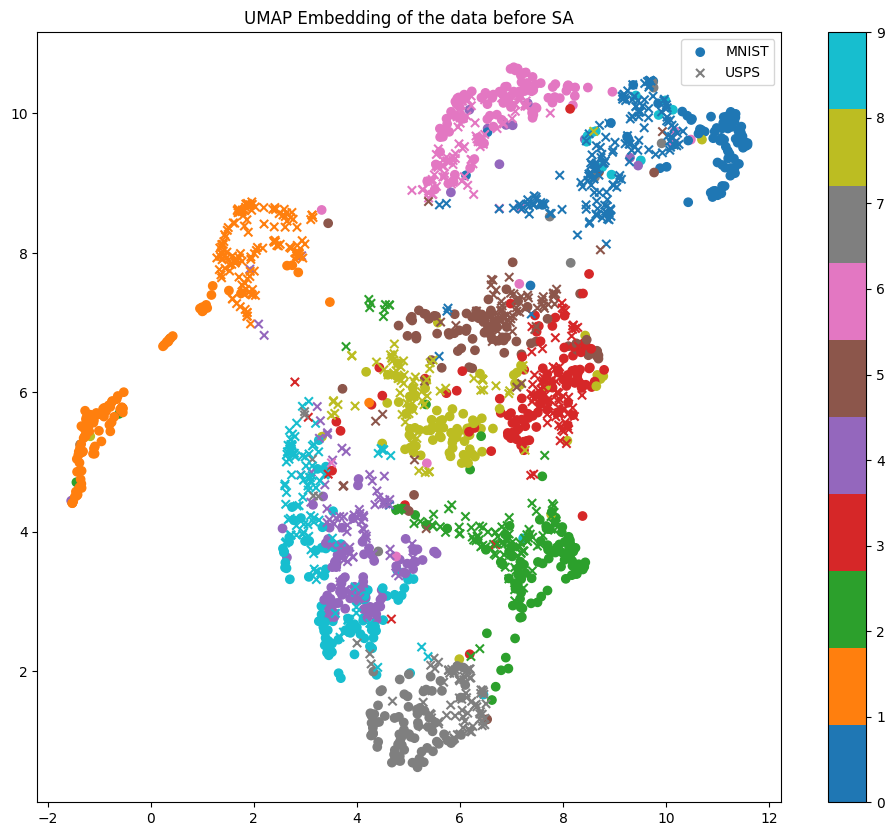

In [261]:
# Reduced Data
xtot=np.concatenate((MNIST_Xtrain_res,USPS_Xtrain_res),axis=0) # all data
nMNIST=MNIST_Xtrain_res.shape[0]
nUSPS=USPS_Xtrain_res.shape[0]

xp = UMAP().fit_transform(xtot) # this should take ~50sec

print(xp.shape)

# separate again but now in 2D
xpMNIST=xp[:nMNIST,:]
xpUSPS=xp[nMNIST:nMNIST+nUSPS,:]

plt.figure(3,(12,10))
plt.scatter(xpMNIST[:,0],xpMNIST[:,1],c=MNIST_ytrain_res,marker='o',cmap='tab10',label='MNIST')
plt.scatter(xpUSPS[:,0],xpUSPS[:,1],c=USPS_ytrain_res,marker='x',cmap='tab10',label='USPS')
plt.legend()
plt.colorbar()
plt.title('UMAP Embedding of the data before SA')
plt.show()

/Users/mjolif/Documents/A-MVA/S2/Representation-learning/TP2/.venv/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


(2000, 2)


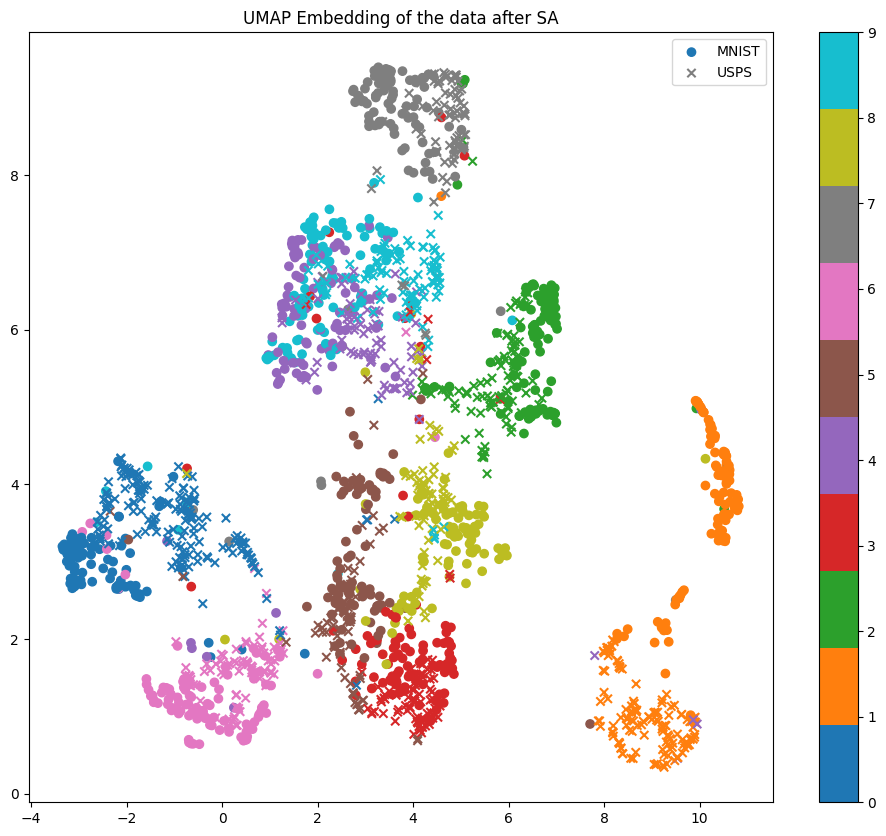

In [262]:
XtrainS_SA, XtestS_SA, XtrainT_SA, XtestT_SA = SA(XtrainS, XtestS, XtrainT, XtestT, d = 50)

xtot=np.concatenate((XtrainS_SA,XtrainT_SA),axis=0) # all data
nMNIST=XtrainS_SA.shape[0]
nUSPS=XtrainT_SA.shape[0]

xp = UMAP().fit_transform(xtot) # this should take ~50sec

print(xp.shape)

# separate again but now in 2D
xpMNIST=xp[:nMNIST,:]
xpUSPS=xp[nMNIST:nMNIST+nUSPS,:]

plt.figure(3,(12,10))
plt.scatter(xpMNIST[:,0],xpMNIST[:,1],c=MNIST_ytrain_res,marker='o',cmap='tab10',label='MNIST')
plt.scatter(xpUSPS[:,0],xpUSPS[:,1],c=USPS_ytrain_res,marker='x',cmap='tab10',label='USPS')
plt.legend()
plt.colorbar()
plt.title('UMAP Embedding of the data after SA')
plt.show()

We observe that after applying the subspace alignement, the two datasets are a bit closer in the UMAP embedding space.

**Question**: Repeat the same experiments for different Source and Target domains. Use at least the two followng configurations:

Source: MNIST, Target: USPS

Source MNIST, Target: SVHN

**Queston**: Comment the results

#### Source MNIST, Target SVHN

In [263]:
# Source domain
XtrainS = MNIST_Xtrain_res
ytrainS = MNIST_ytrain_res
XtestS = MNIST_Xtest
ytestS = MNIST_ytest

# Target domain
XtrainT = SVHN_Xtrain_res
ytrainT = SVHN_ytrain_res
XtestT = SVHN_Xtest
ytestT = SVHN_ytest

Ns=1000 # number of samples in source domain
Nt=1000 # number of samples in target domain

XtrainS = XtrainS[:Ns,:]
ytrainS = ytrainS[:Ns]
XtestT = XtestT[:Nt,:]
ytrainT = ytrainT[:Nt]
ytestT = ytestT[:Nt]

In [264]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

LR = LogisticRegression(max_iter=500)
LR.fit(XtrainS, ytrainS)
y_pred_test = LR.predict(XtestT)
print("Accuracy", accuracy_score(ytestT, y_pred_test))

Accuracy 0.08


In [265]:
d_list = [1, 2, 5, 10, 20, 50, 100]

for d in d_list:
    XtrainS_pca, XtestS_pca, XtrainT_pca, XtestT_pca = transform(XtrainS, XtestS, XtrainT, XtestT, d = d)
    
    LR = LogisticRegression(max_iter=500)
    LR.fit(XtrainS_pca, ytrainS)
    y_pred_test = LR.predict(XtestT_pca)
    print(f"Accuracy for d = {d}: ", accuracy_score(ytestT, y_pred_test))

Accuracy for d = 1:  0.089
Accuracy for d = 2:  0.098
Accuracy for d = 5:  0.085
Accuracy for d = 10:  0.084
Accuracy for d = 20:  0.086
Accuracy for d = 50:  0.094
Accuracy for d = 100:  0.086


In [266]:
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC

d_list = [1, 2, 5, 10, 20, 50, 100]

for d in d_list:
    print(f"###1 Accuracy for d = {d} ####")
    XtrainS_SA, XtestS_SA, XtrainT_SA, XtestT_SA = SA(XtrainS, XtestS, XtrainT, XtestT, d = d)
    
    #Linear model
    LR = LogisticRegression(max_iter=500)
    LR.fit(XtrainS_SA, ytrainS)
    y_pred_test = LR.predict(XtestT_SA)
    print(f"Logistic Regression: ", accuracy_score(ytestT, y_pred_test))
    
    #non-linear model (RBF-kernel)
    SVM = SVC(kernel = 'rbf')
    SVM.fit(XtrainS_SA, ytrainS)
    y_pred_test = SVM.predict(XtestT_SA)
    print(f"SVM: ", accuracy_score(ytestT, y_pred_test))

    #deep learning model
    MLP = MLPClassifier(hidden_layer_sizes = (512, 10), max_iter = 2000)
    MLP.fit(XtrainS_SA, ytrainS)
    y_pred_test = MLP.predict(XtestT_SA)
    print(f"MLP: ", accuracy_score(ytestT, y_pred_test))

###1 Accuracy for d = 1 ####
Logistic Regression:  0.07
SVM:  0.07
MLP:  0.07
###1 Accuracy for d = 2 ####
Logistic Regression:  0.069
SVM:  0.07
MLP:  0.072
###1 Accuracy for d = 5 ####
Logistic Regression:  0.075
SVM:  0.071
MLP:  0.09
###1 Accuracy for d = 10 ####
Logistic Regression:  0.086
SVM:  0.178
MLP:  0.062
###1 Accuracy for d = 20 ####
Logistic Regression:  0.083
SVM:  0.18
MLP:  0.079
###1 Accuracy for d = 50 ####
Logistic Regression:  0.125
SVM:  0.112
MLP:  0.097
###1 Accuracy for d = 100 ####
Logistic Regression:  0.105
SVM:  0.153
MLP:  0.173


/Users/mjolif/Documents/A-MVA/S2/Representation-learning/TP2/.venv/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


(2000, 2)


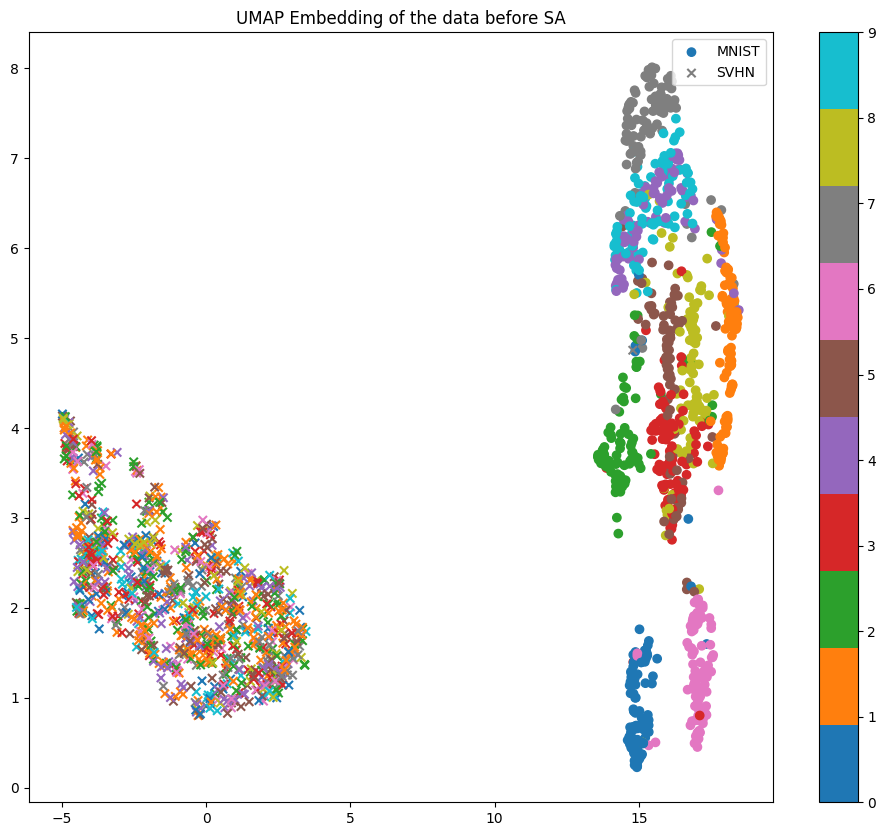

In [267]:
# Reduced Data
xtot=np.concatenate((MNIST_Xtrain_res,SVHN_Xtrain_res),axis=0) # all data
nMNIST=MNIST_Xtrain_res.shape[0]
nSVHN=SVHN_Xtrain_res.shape[0]

xp = UMAP().fit_transform(xtot) # this should take ~50sec

print(xp.shape)

# separate again but now in 2D
xpMNIST=xp[:nMNIST,:]
xpSVHN=xp[nMNIST:nMNIST+nSVHN,:]

plt.figure(3,(12,10))
plt.scatter(xpMNIST[:,0],xpMNIST[:,1],c=MNIST_ytrain_res,marker='o',cmap='tab10',label='MNIST')
plt.scatter(xpSVHN[:,0],xpSVHN[:,1],c=SVHN_ytrain_res,marker='x',cmap='tab10',label='SVHN')
plt.legend()
plt.colorbar()
plt.title('UMAP Embedding of the data before SA')
plt.show()

/Users/mjolif/Documents/A-MVA/S2/Representation-learning/TP2/.venv/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


(2000, 2)


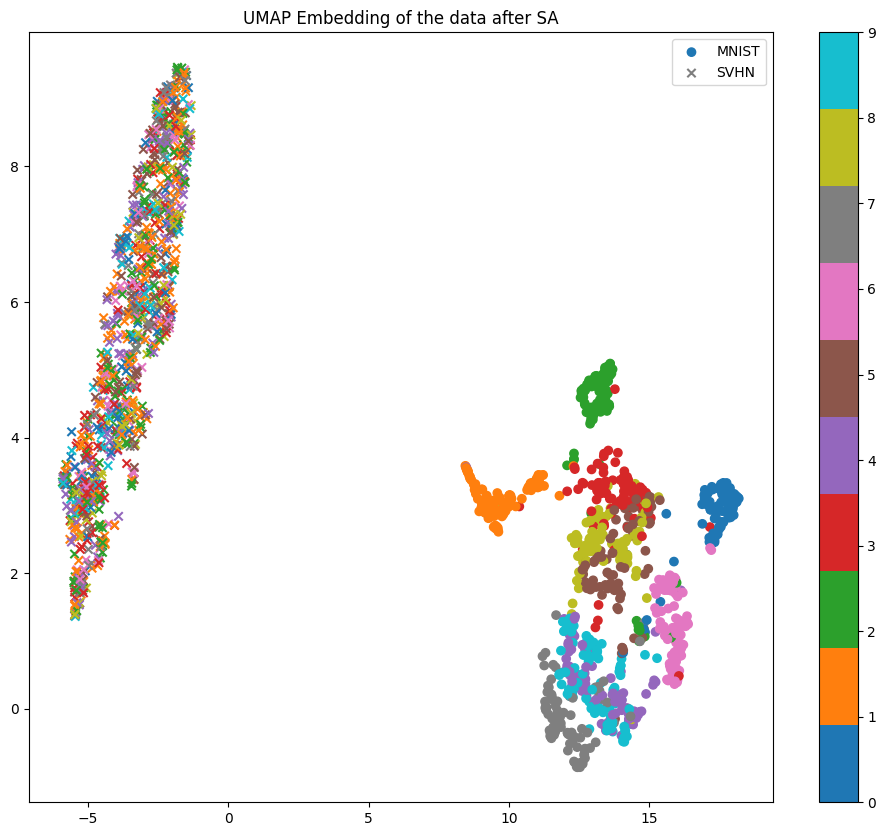

In [268]:
XtrainS_SA, XtestS_SA, XtrainT_SA, XtestT_SA = SA(XtrainS, XtestS, XtrainT, XtestT, d = 50)

xtot=np.concatenate((XtrainS_SA,XtrainT_SA),axis=0) # all data
nMNIST=XtrainS_SA.shape[0]
nSVHN=XtrainT_SA.shape[0]

xp = UMAP().fit_transform(xtot) # this should take ~50sec

print(xp.shape)

# separate again but now in 2D
xpMNIST=xp[:nMNIST,:]
xpSVHN=xp[nMNIST:nMNIST+nSVHN,:]

plt.figure(3,(12,10))
plt.scatter(xpMNIST[:,0],xpMNIST[:,1],c=MNIST_ytrain_res,marker='o',cmap='tab10',label='MNIST')
plt.scatter(xpSVHN[:,0],xpSVHN[:,1],c=SVHN_ytrain_res,marker='x',cmap='tab10',label='SVHN')
plt.legend()
plt.colorbar()
plt.title('UMAP Embedding of the data after SA')
plt.show()

When MNIST is the source and SVHN is the target dataset, it doesn't help to use subspace alignment to improve the performance a lot. This can be explained by the fact that the distributions of the MNIST and SVHN datasets are too different and that subspace alignment can't overcome it.

**Question**: What does it happen if you decrease the number of samples for the labeled training set? Is it expected based on the theory seen during the lecture ?

By changing

```Ns=1000 # number of samples in source domain and Nt=1000 # number of samples in target domain```

We can observe that decreasing the number of samples of the labeled training set can reduce the classification results obtained by around 10% in the case of subspace alignement, it was expected based on the theory seen during the lecture. Indeed, the best performance that we can long for, if we had an infinite number of
training/test samples in both domains, which is a consequence of Th2. in "Learning Bounds for Domain Adaptation".


**Optional**: You can test other methods using the `adapt`library. See `https://adapt-python.github.io/adapt/`

Here, you can test the MDD and DANN methods using a very simple architecture for both the encoder and discriminator.

In [269]:
from adapt.feature_based import MDD
import tensorflow as tf


# Define the encoder model
encoder = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(XtrainS.shape[1],)),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
])

# Define the task model (the classifier)
task = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(64,)),  # Same size as the output of encoder
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')  # Assuming a 10-class classification task
])

model = MDD(encoder=encoder,task=task,lambda_=0.1, gamma=4., Xt=XtrainT, metrics=["accuracy"], random_state=0)
model.fit(XtrainS, ytrainS, epochs=100, verbose=0)
model.score(XtrainS, ytrainS)

/Users/mjolif/Documents/A-MVA/S2/Representation-learning/TP2/.venv/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


AttributeError: 'MDD' object has no attribute '_is_compiled'

In [ ]:
from adapt.feature_based import DANN

model = DANN(XXXXXX)
model.fit(XXXXXX)
model.score(XXXXXXX)


**Question (Optional)**: try to use a more complex architecture (for instance a pre-trained model) for both the encoder and discriminator. Be careful, the adapt library is written in TensorFlow...